In [10]:
# !rm -rf WGAN
# !rm -rf WGAN.zip
!unzip WGAN.zip
# !pip install pot

Archive:  WGAN.zip
   creating: WGAN/
  inflating: WGAN/Losses.py          
  inflating: WGAN/NNs.py             
  inflating: WGAN/utils.py           
   creating: WGAN/__pycache__/
  inflating: WGAN/__pycache__/Losses.cpython-37.pyc  
  inflating: WGAN/__pycache__/NNs.cpython-37.pyc  
  inflating: WGAN/__pycache__/utils.cpython-37.pyc  


In [11]:
from WGAN.NNs import DiscriminatorMLP, DiscriminatorConvNet
from WGAN.utils import divide_by_classes, Trainer
from WGAN.Losses import GPLoss, WCLoss, WeightClipper, CEpsilonLoss, CLoss, LPLoss

In [12]:
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as vutils

from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
from tqdm.notebook import tqdm

from itertools import product

In [3]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize((32, 32)),
    ]
)

In [6]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

import MNIST

--2021-03-23 20:44:14--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-23 20:44:14--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  6.78MB/s    in 14s     

2021-03-23 20:44:28 (2.39 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [5]:
datasets_names = ['CIFAR10', 'MNIST']
datasets_check = {'CIFAR10': (datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=True),
                        datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=False)),
            'MNIST': (datasets.MNIST(root = './', train=True, download=True, transform=transform),
                      datasets.MNIST(root = './', train=False, download=True, transform=transform))}

batch_sizes = list(product([64, 512], [64, 512]))

models = []

dataset_name = 'CIFAR10'
dataset_train, dataset_test = datasets_check[dataset_name]
N, M = batch_sizes[0]

train_part1, train_part2 = divide_by_classes(dataset_train, N, cifar=True)
test_part1, test_part2 = divide_by_classes(dataset_test, M, cifar=True)

check_image = next(iter(train_part1))

epochs = 20
num_of_channels = check_image.size(1)
image_size = check_image.size(2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

trainer = Trainer(
    criterion=WCLoss(),
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    weight_clipper=WeightClipper(0.08)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -7.5275646



Val epoch 1 , Mean error : -7.3453963



Val epoch 2 , Mean error : -7.0541749



Val epoch 3 , Mean error : -6.6751726



Val epoch 4 , Mean error : -6.1993294



Val epoch 5 , Mean error : -5.6696237



Val epoch 6 , Mean error : -5.1179841



Val epoch 7 , Mean error : -4.5782977



Val epoch 8 , Mean error : -4.03034



Val epoch 9 , Mean error : -3.5309481



Val epoch 10 , Mean error : -3.0779695



Val epoch 11 , Mean error : -2.645656



Val epoch 12 , Mean error : -2.239574



Val epoch 13 , Mean error : -1.870388



Val epoch 14 , Mean error : -1.5308641



Val epoch 15 , Mean error : -1.2324282



Val epoch 16 , Mean error : -0.94510083



Val epoch 17 , Mean error : -0.66588417



Val epoch 18 , Mean error : -0.39666383



Val epoch 19 , Mean error : -0.15485558


Average error for conv is: 4.854+-0.157


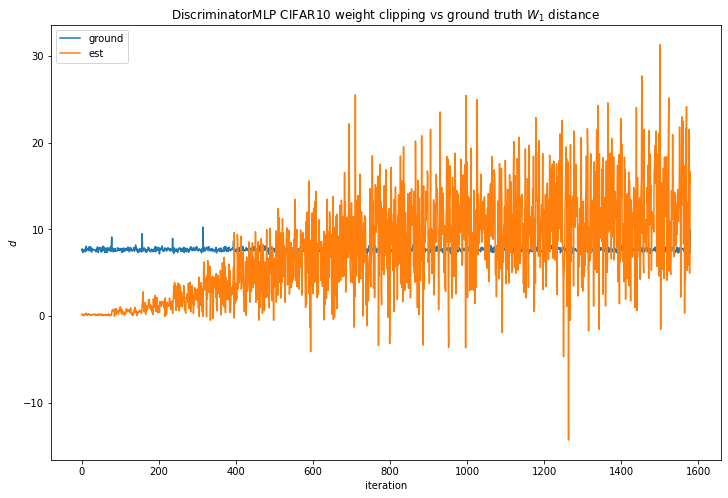

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} weight clipping vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 4.854+-0.157


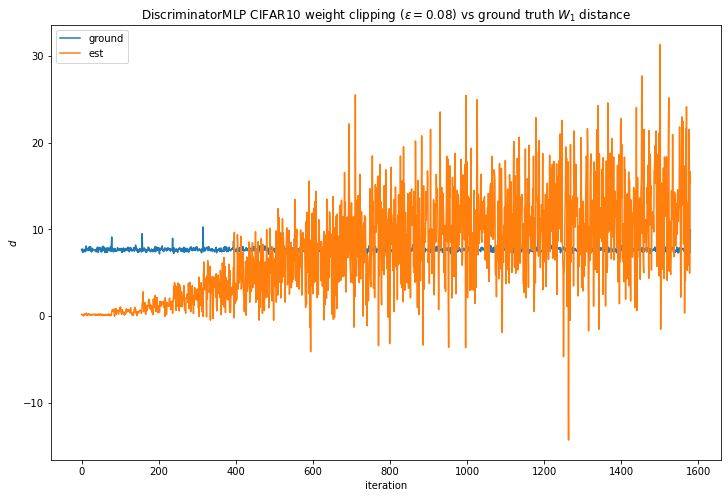

In [ ]:
with PdfPages(r'{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} weight clipping $(\epsilon = {})$ vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name, 0.08));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_CIFAR10.pdf /content/drive/MyDrive/MLProject/MLP/CIFAR

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = GPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.005

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -8.763013



Val epoch 1 , Mean error : -8.3970577



Val epoch 2 , Mean error : -8.1965458



Val epoch 3 , Mean error : -8.0890589



Val epoch 4 , Mean error : -8.0394369



Val epoch 5 , Mean error : -8.0276838



Val epoch 6 , Mean error : -7.9784372



Val epoch 7 , Mean error : -7.9487035



Val epoch 8 , Mean error : -7.9296274



Val epoch 9 , Mean error : -7.9034683



Val epoch 10 , Mean error : -7.881277



Val epoch 11 , Mean error : -7.8615123



Val epoch 12 , Mean error : -7.8461696



Val epoch 13 , Mean error : -7.8350801



Val epoch 14 , Mean error : -7.8485178



Val epoch 15 , Mean error : -7.8508132



Val epoch 16 , Mean error : -7.8410606



Val epoch 17 , Mean error : -7.8336001



Val epoch 18 , Mean error : -7.825833



Val epoch 19 , Mean error : -7.8194964


Average error for conv is: 7.819+-0.017


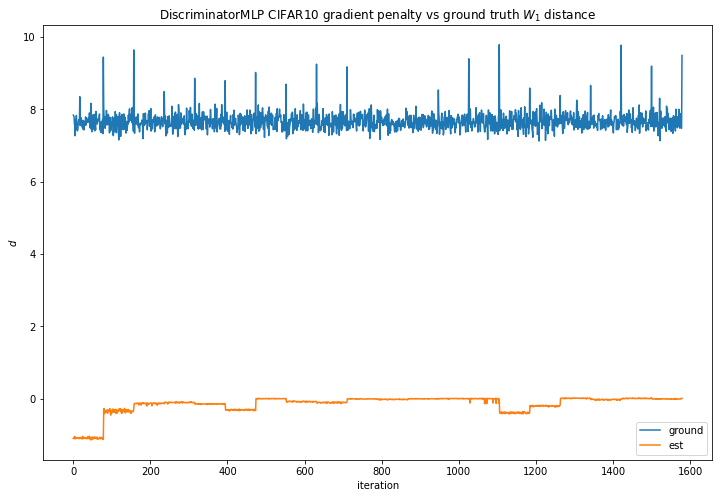

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 7.819+-0.017


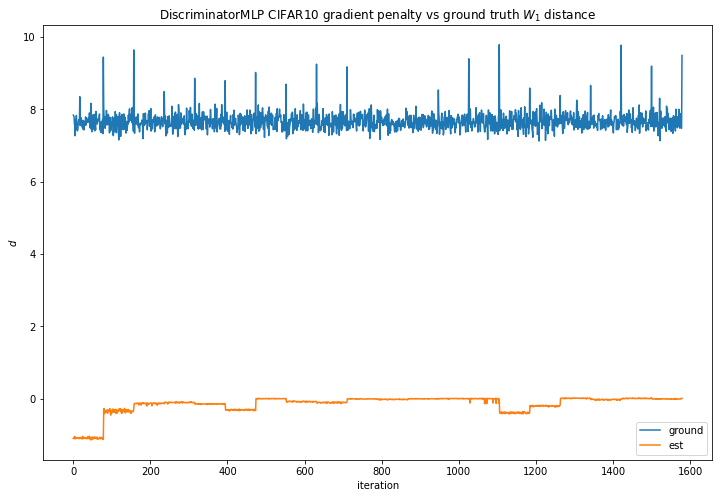

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_CIFAR10_GPLoss.pdf /content/drive/MyDrive/MLProject/MLP/CIFAR

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = LPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -7.6471532



Val epoch 1 , Mean error : -7.6467171



Val epoch 2 , Mean error : -7.6397713



Val epoch 3 , Mean error : -7.6412675



Val epoch 4 , Mean error : -7.6403285



Val epoch 5 , Mean error : -7.6429618



Val epoch 6 , Mean error : -7.6442388



Val epoch 7 , Mean error : -7.6459157



Val epoch 8 , Mean error : -7.6443407



Val epoch 9 , Mean error : -7.6441046



Val epoch 10 , Mean error : -7.6443559



Val epoch 11 , Mean error : -7.6448555



Val epoch 12 , Mean error : -7.6453267



Val epoch 13 , Mean error : -7.6435065



Val epoch 14 , Mean error : -7.6437268



Val epoch 15 , Mean error : -7.6441655



Val epoch 16 , Mean error : -7.6436398



Val epoch 17 , Mean error : -7.6442936



Val epoch 18 , Mean error : -7.6436431



Val epoch 19 , Mean error : -7.6423488


Average error for conv is: 7.642+-0.011


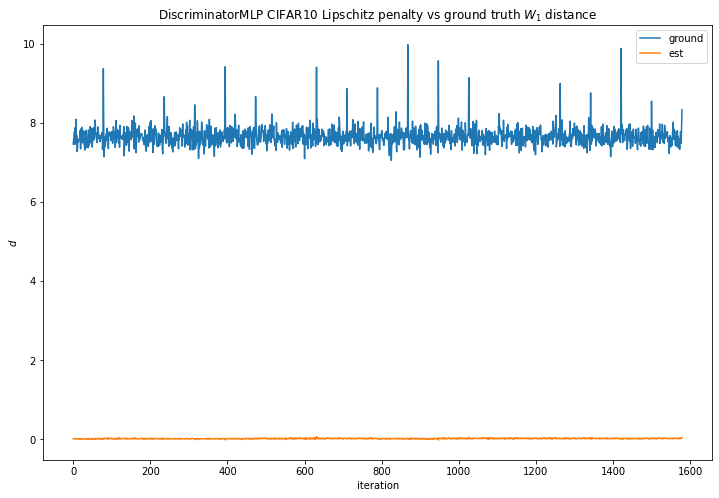

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 7.642+-0.011


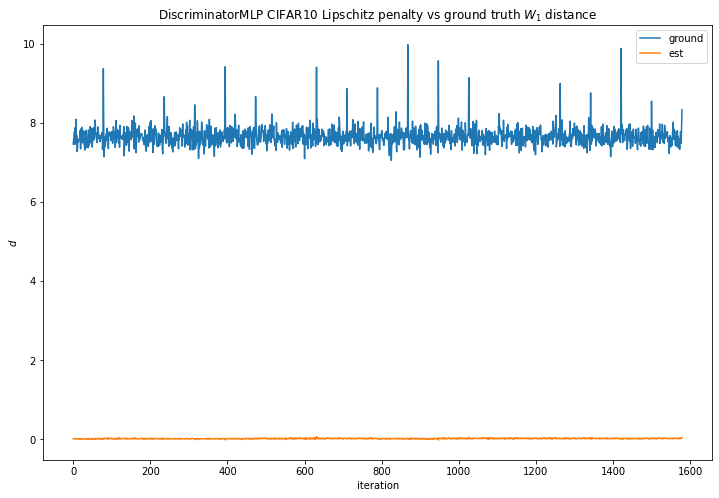

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_CIFAR10_LPLoss.pdf /content/drive/MyDrive/MLProject/MLP/CIFAR

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CLoss()
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -0.56038788



Val epoch 1 , Mean error : -0.53766335



Val epoch 2 , Mean error : -0.52611361



Val epoch 3 , Mean error : -0.51353312



Val epoch 4 , Mean error : -0.50326359



Val epoch 5 , Mean error : -0.49255046



Val epoch 6 , Mean error : -0.48532154



Val epoch 7 , Mean error : -0.48290579



Val epoch 8 , Mean error : -0.47807302



Val epoch 9 , Mean error : -0.47718018



Val epoch 10 , Mean error : -0.47246907



Val epoch 11 , Mean error : -0.46757666



Val epoch 12 , Mean error : -0.46499832



Val epoch 13 , Mean error : -0.46156794



Val epoch 14 , Mean error : -0.45857967



Val epoch 15 , Mean error : -0.45530221



Val epoch 16 , Mean error : -0.45287879



Val epoch 17 , Mean error : -0.45094399



Val epoch 18 , Mean error : -0.44846708



Val epoch 19 , Mean error : -0.44755177


Average error for conv is: 0.448+-0.005


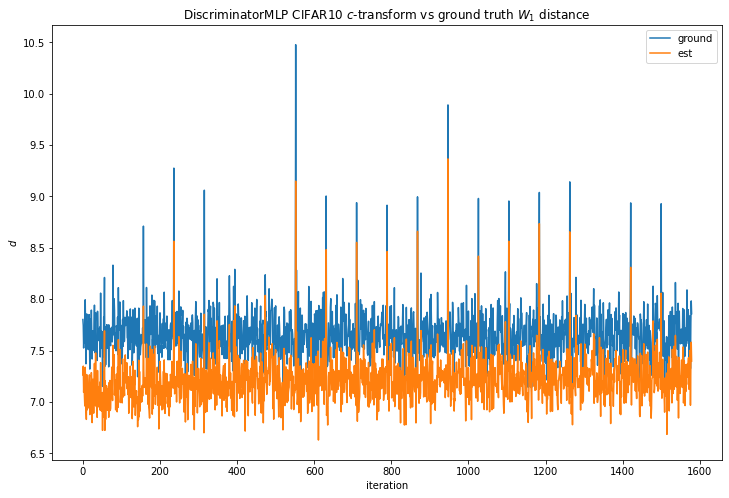

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} $c$-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 0.448+-0.005


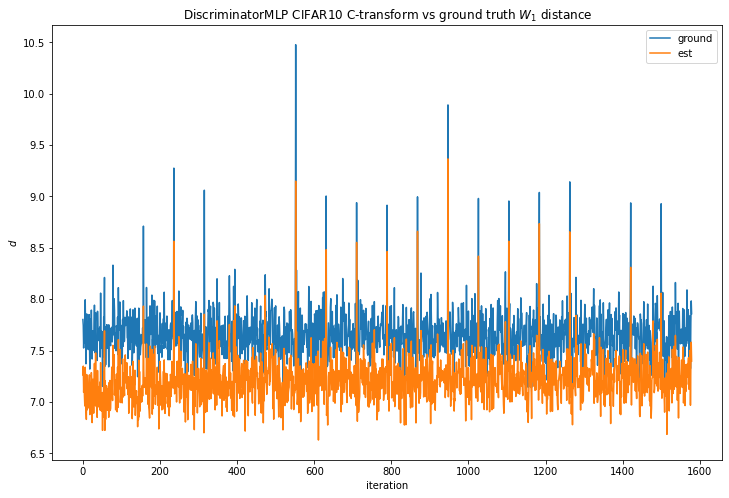

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} C-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_CIFAR10_CLoss.pdf /content/drive/MyDrive/MLProject/MLP/CIFAR

In [13]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CEpsilonLoss(1)
criterion.optimizer_params['lr'] = 0.0001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)

TypeError: ignored

Average error for conv is: 1.696+-0.008


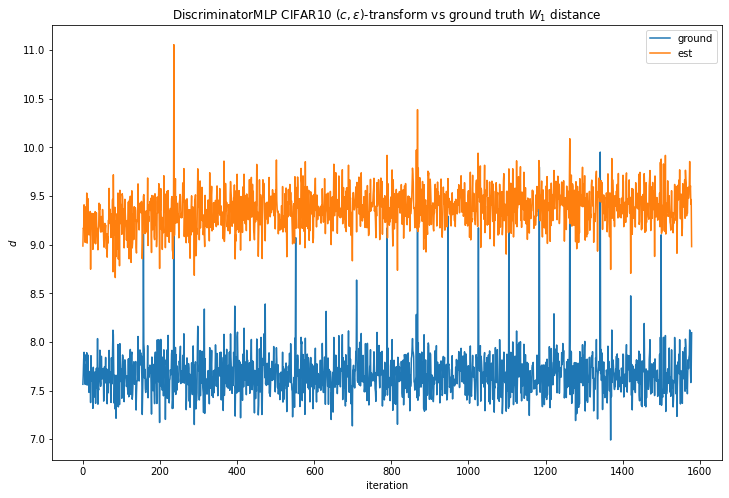

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} ($c, \epsilon$)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 1.696+-0.008


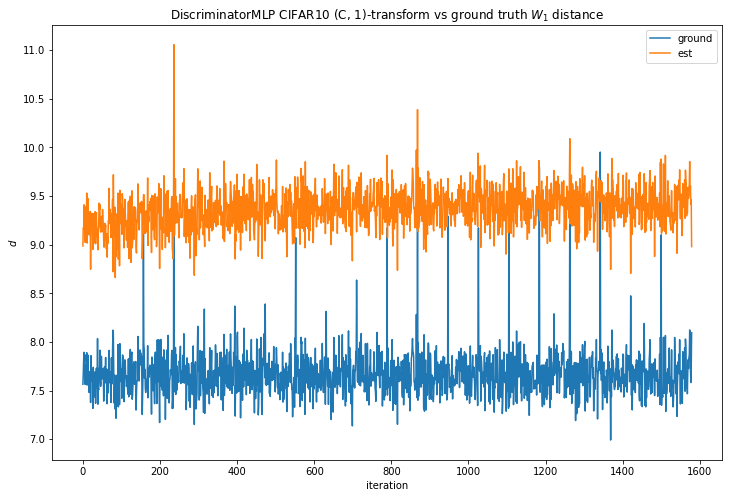

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} (C, 1)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_CIFAR10_CEpsilonLoss.pdf /content/drive/MyDrive/MLProject/MLP/CIFAR